<a href="https://colab.research.google.com/github/adanpinnero/PercepcionAct01/blob/main/keystone_3_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 1: Herramienta para corregir el efecto Keystone en imagénes

**Alumnos:** Pablo García Catalán, Adán Piñero Alquegui, Asier Balza de Vallejo Julián, Alejandro León Alonso.<br>
**Asignatura:** Percepción computacional 2020-21.<br>
**Exposición oral:** Para la exposición oral son alumnos voluntarios Pablo G. Asier B. y Adán P. <br> 

| <div style="text-align: center"> Alumno </div>| Asistencias a reuniones (0-3) | Entregas realizadas (0-3) |
| --- | --- | --- |
| <div style="text-align: left"> Pablo García Catalán </div> | 3 | 3 |
| <div style="text-align: left"> Adán Piñero Alquegui </div> | 3 | 3 |
| <div style="text-align: left"> Asier Balza de Vallejo Julián </div> | 3 | 3 |
| <div style="text-align: left"> Alejandro León Alonso </div> | 3 | 3 |

**Índice:**<br>

1. Planteamiento del problema<br>
2. Corrección Keystone lineal<br>
3. Corrección Keystone full width<br>
4. Corrección Keystone horizonte<br>
5. Determinación de alpha<br>
6. Ejemplos de uso<br>
7. Conclusión<br>
ANEXO. Determinación automática de alpha<br>

#### 1.- Planteamiento del problema. El efecto Keystone
El efecto keystone se produce cuando el sensor de la cámara no es paralelo con el plano que se desea fotografiar. De esta forma, al inclinarse el sensor habrá zonas del objeto a fotografiar más próximas y otras más alejadas, provocando que las líneas paralelas en la realidad puedan capturarse como oblicuas en la imágen. Este efecto se produce a menudo al intentar capturar elementos de gran altura, siendo necesario inclinar la cámara para visualizarlos en su totalidad. También puede darse esta circunstancia en imágenes capturadas desde drones e incluso desde satélites, donde no siempre es posible asegurar el adecuado posicionamiento del sensor. Este efecto puede ser intencionado en ocasiones o bien corregido modificando la ubicación de la cámara, la inclinación del sensor, utilizando un objetivo de ángulo variable o post procesando la imagen capturada. En este laboratorio se plantea un algoritmo que corrija el efecto keystone, considerándose que puede ser útil en especial en fotografía arquitectónica o desde posiciones comprometidas del sensor como pueden ser los drones o los satélites.

A continuación se muestran tres ejemplos del efecto keystone producido al inclinar la cámara en fotografía arquitectónica.

In [ ]:
# Se importan librerias para operaciones numéricas y de imagen.
import numpy as np
import skimage
from skimage import io
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'IMAGEN ORIGINAL 03')

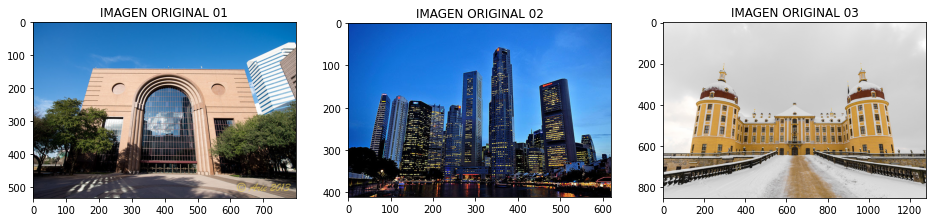

In [ ]:
# Se cargan tres imágenes que presentan efecto keystone
fig1, (ax0,ax1,ax2) = plt.subplots(ncols=3, figsize=(16, 6))
img_1=skimage.io.imread(fname="https://i.ibb.co/3rqF85Z/keystone-1.jpg")
img_2=skimage.io.imread(fname="https://i.ibb.co/MP9qD1n/keystone-2.jpg")
img_3=skimage.io.imread(fname="https://i.ibb.co/NskzNnD/keystone-3.jpg")
ax0.imshow(img_1)
ax0.set_title("IMAGEN ORIGINAL 01")
ax1.imshow(img_2)
ax1.set_title("IMAGEN ORIGINAL 02")
ax2.imshow(img_3)
ax2.set_title("IMAGEN ORIGINAL 03")

La función corrige_keystone(img,alpha,modo) será la encargada de aplicar la herramienta para corregir el efecto keystone. Sus argumentos serán la imagen a corregir, en color y de cualquier tamaño, el parámetro que hemos denominado alpha y está relacionado con el alcance de la corrección aplicada y el modo. Respecto al modo se han desarrollado tres diferentes que se explicarán en apartados sucesivos; ln:lineal, fw:fullwidth, hz:horizonte.

In [ ]:
def corrige_keystone(img,alpha,modo):
    transformada=np.zeros(img.shape) #crea una matriz de ceros sobre la que implementar la solución.
    original_shape=img.shape
# MODO LINEAL
    if(modo=="ln" or modo=="ln_sr"):#Itera sobre cada pìxel de la imagen original
        #Posiciono cada pixel de la matriz original en la nueva modificando su posición de acuerdo a la funcion ln
        for posicion,valor in np.ndenumerate(img[:,:,:]):
            if(x_transformada_lineal(posicion[1],posicion[0],alpha,original_shape) in range(0,original_shape[1])):
                transformada[posicion[0],x_transformada_lineal(posicion[1],posicion[0],alpha,original_shape),posicion[2]]=valor
        if(modo=="ln_sr"): #imagen corregida sin recortar
            return transformada.astype(int)
        else: # imagen corregida recortada
            return recortar_imagen_corregida(transformada.astype(int),alpha)
# MODO FULLWIDTH  
    if(modo=="fw" or modo=="fw_sr"): #Itera sobre cada pìxel de la imagen original
        #Posiciono cada pixel de la matriz original en la nueva modificando su posición de acuerdo a la funcion fw
        if(modo=="fw_sr"):#Fullwidth sin rellenar valores en negro
            for posicion,valor in np.ndenumerate(img[:,:,:]):
                if(x_transformada_fullwidth(posicion[1],posicion[0],alpha,original_shape) in range(0,original_shape[1])):
                    transformada[posicion[0],x_transformada_fullwidth(posicion[1],posicion[0],alpha,original_shape),posicion[2]]=valor
            return transformada.astype(int)
        else:#Fullwidth rellenando valores en negro
            #Posiciono cada pixel de la matriz original en la nueva modificando su posición de acuerdo a la funcion hz
            for posicion,valor in np.ndenumerate(img[:,:,:]):
                posicion_x_nueva  = x_transformada_fullwidth(posicion[1],posicion[0],alpha,original_shape)
                if not(posicion_x_nueva < 0 or posicion_x_nueva >= img.shape[1]): #la funcion ha expandido fuera de la imagen
                    #Relleno los píxeles que permanecen a cero al expandir la imagen
                    transformada[posicion[0],posicion_x_nueva,posicion[2]]=valor
                    saltopixel = posicion_x_nueva - posicion_anterior
                    if (saltopixel > 1):
                        transformada[posicion[0],posicion_x_nueva - 1,0] = valor_anterior_RGB0
                        transformada[posicion[0],posicion_x_nueva - 1,1] = valor_anterior_RGB1
                        transformada[posicion[0],posicion_x_nueva - 1,2] = valor_anterior_RGB2
                posicion_anterior = posicion_x_nueva    #guardamos el valor transformado para comparar la siguiente iterac
                if (posicion[2] == 0): valor_anterior_RGB0 = valor
                if (posicion[2] == 1): valor_anterior_RGB1 = valor
                if (posicion[2] == 2): valor_anterior_RGB2 = valor
            return transformada.astype(int)
# MODO HORIZONTE
    if(modo=="hz" or modo=="hz_sr"):#Itera sobre cada pìxel de la imagen original
        x_central=int(img.shape[1]*0.5)
        y_central=int(img.shape[0]*0.5)
        x_max=int(img.shape[1])
        #Posiciono cada pixel de la matriz original en la nueva modificando su posición de acuerdo a la funcion hz
        for posicion,valor in np.ndenumerate(img[:,:,:]):
            posicion_x_nueva  = x_transformada_horizonte(posicion[1],posicion[0],alpha,x_central,y_central)
            if not(posicion_x_nueva < 0 or posicion_x_nueva >= x_max): #la funcion ha expandido fuera de la imagen
                #Relleno los píxeles que permanecen a cero al expandir la imagen
                transformada[posicion[0],posicion_x_nueva,posicion[2]]=valor
                saltopixel = posicion_x_nueva - posicion_anterior
                if (saltopixel > 1):
                    transformada[posicion[0],posicion_x_nueva - 1,0] = valor_anterior_RGB0
                    transformada[posicion[0],posicion_x_nueva - 1,1] = valor_anterior_RGB1
                    transformada[posicion[0],posicion_x_nueva - 1,2] = valor_anterior_RGB2
            posicion_anterior = posicion_x_nueva    #guardamos el valor transformado para comparar la siguiente iterac
            if (posicion[2] == 0): valor_anterior_RGB0 = valor
            if (posicion[2] == 1): valor_anterior_RGB1 = valor
            if (posicion[2] == 2): valor_anterior_RGB2 = valor
        if(modo=="hz_sr"): #Imagen sin recortar
            return transformada.astype(int)
        else: #Imagen recortada
            return recortar_imagen_corregida(transformada.astype(int),alpha*0.5)

#### 2.- CORRECCIÓN KEYSTONE MODO LINEAL
La primera transformación consiste en modificar la posición x de los pixeles de tal manera que esta deformación sea directamente proporcional a la altura de la imagen y a la distancia a su eje vertical central. De esta forma se pretende corregir un defecto lineal oblicuo con una transformación en sentido opuesto. Se pierde parte de la imagen por lo que se procede a recortar.

In [ ]:
#Definir funciones

def x_transformada_lineal(x,y,alpha,original_shape):
    x_central=int(original_shape[1]*0.5)
    if(x<=x_central):
        return round(x+(y*alpha)*((x_central-x)/x_central))
    if(x>x_central):
        return round(x-(y*alpha)*((x-x_central))/x_central)

# Funcion recorte automatico
def recortar_imagen_corregida(img,alpha):
    y_original,x_original,z_original=img.shape
    primera_x=x_transformada_lineal(0,y_original,alpha,img.shape)
    ultima_x=x_original-primera_x
    return img[:,primera_x:ultima_x,:]

Text(0.5, 1.0, 'KEYSTONE LINEAL')

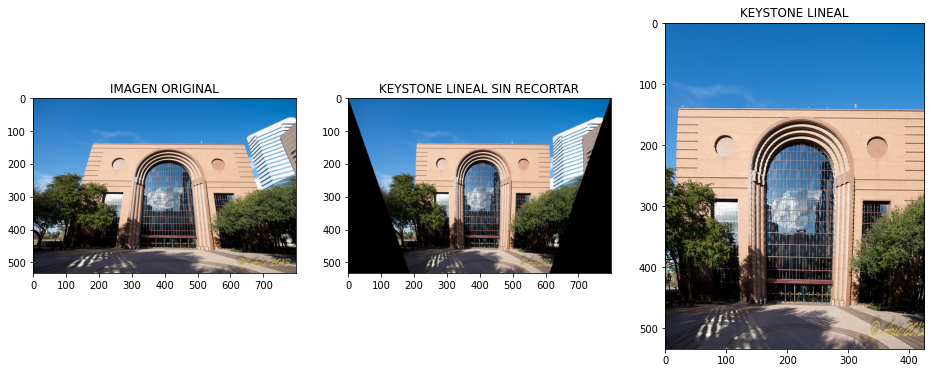

In [ ]:
fig2, (ax0,ax1,ax2) = plt.subplots(ncols=3, figsize=(16, 6))
ax0.imshow(img_1)
ax0.set_title("IMAGEN ORIGINAL")
ax1.imshow(corrige_keystone(img_1,0.35,"ln_sr"))
ax1.set_title("KEYSTONE LINEAL SIN RECORTAR")
ax2.imshow(corrige_keystone(img_1,0.35,"ln"))
ax2.set_title("KEYSTONE LINEAL")

#### 3.- CORRECCIÓN KEYSTONE MODO FULL WIDTH
La transformación lineal planteada comprime la zona inferior de la imagen, perdiendo en ocasiones una parte importante de la imagen. La siguiente transformación, denominada fullwidth pretende mantener el ancho de la imagen original. Al generarse pixeles sin información se rellenarán con información propia de los vecinos. Se pretende que esta deformación mantenga el ancho total de la imagen así como su altura por lo que sufrirá una ligera deformación en las proporciones resultantes. También requiere alphas mayores.

In [ ]:
def x_transformada_fullwidth(x,y,alpha,original_shape):
    y_original,x_original,z_original=original_shape
    primera_x=x_transformada_lineal(0,y_original,alpha,original_shape)
    x_central=int(original_shape[1]*0.5)
    if(x<=x_central):
        return round(-primera_x*((x_central-x)/x_central)+x+(y*alpha)*((x_central-x)/x_central))
    if(x>x_central):
        return round(primera_x*((x-x_central)/x_central)+x-(y*alpha)*((x-x_central))/x_central)

Text(0.5, 1.0, 'MODO FULLWIDTH')

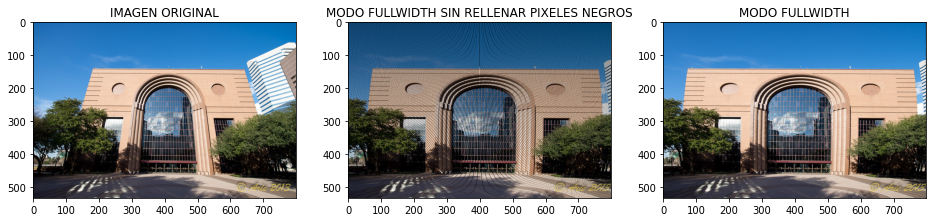

In [ ]:
fig3, (ax0,ax1,ax2) = plt.subplots(ncols=3, figsize=(16, 6))
ax0.imshow(img_1)
ax0.set_title("IMAGEN ORIGINAL")
ax1.imshow(corrige_keystone(img_1,0.50,"fw_sr"))
ax1.set_title("MODO FULLWIDTH SIN RELLENAR PIXELES NEGROS")
ax2.imshow(corrige_keystone(img_1,0.50,"fw"))
ax2.set_title("MODO FULLWIDTH")

#### 4.- CORRECCIÓN KEYSTONE HORIZONTE
La pérdida en la corrección lineal parece excesiva y los resultados en la corrección fullwidth generan una distorsión de las proporciones importante. Se observa que la corrección adecuada puede ser aquella donde la modificación lineal de las posiciones se haga de forma expansiva sobre la linea horizontal central de la imagen y contractiva en bajo la misma. De esta forma se ha desarrollado esta tercera opción, denominada horizonte y que es la más adecuada para resolver el efecto de forma general.

In [ ]:
def x_transformada_horizonte(x,y,alpha,x_central,y_central):
    if(y>=y_central):     #proceso de la mitad inferior de la imagen CONTRAE LA IMAGEN (Pierde información)
        if(x<=x_central): #proceso del cuadrante inferior izquierdo
            return round(x+((y-y_central)*alpha)*((x_central-x)/x_central))
        if(x>x_central):  #proceso del cuadrante inferior izquierdo
            return round(x-((y-y_central)*alpha)*((x-x_central))/x_central)
    else:                 #proceso de la mitad superior de la imagen EXPANDE LA IMAGEN (Genera información)
        if(x<=x_central): #proceso del cuadrante superior derecho
            return round(x+((y-y_central)*alpha*(1+alpha))*((x_central-x)/x_central))
        if(x>x_central):  #proceso del cuadrante superior derecho
            return round(x-((y-y_central)*alpha*(1+alpha))*((x-x_central))/x_central)

Text(0.5, 1.0, 'MODO HORIZONTE')

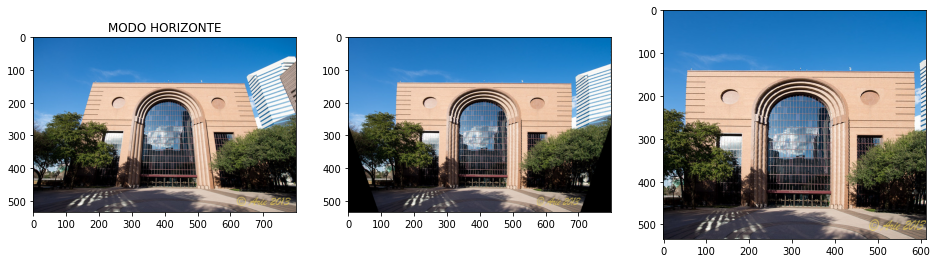

In [ ]:
fig4, (ax0,ax1,ax2) = plt.subplots(ncols=3, figsize=(16, 6))
ax0.imshow(img_1)
ax0.set_title("IMAGEN ORIGINAL")
ax1.imshow(corrige_keystone(img_1,0.35,"hz_sr"))
ax0.set_title("MODO HORIZONTE SIN RECORTAR")
ax2.imshow(corrige_keystone(img_1,0.35,"hz"))
ax0.set_title("MODO HORIZONTE")

A modo de extra se incluye la herramienta horizonte, mediante la función corrige_keystone_exp(img,alpha,porcent): donde porcent permite modificar la línea horizontal utilizada como cero en la deformación lineal. Puede ser de utilidad en casos concretos.

In [ ]:
def x_transformada_exp(x,y,alpha,x_central,y_max):
    if(x<=x_central):
        return round(x+x_central+(y*alpha-alpha*y_max)*((x_central-x)/x_central))
    if(x>x_central):
        return round(x+x_central-(y*alpha-alpha*y_max)*((x-x_central))/x_central)

In [ ]:
def recortar_imagen_corregida_exp(img,alpha):
    primera_x=int((img.shape[1])/4)
    ultima_x=int((3*img.shape[1])/4)
    return img[:,primera_x:ultima_x,:]

In [ ]:
def corrige_keystone_exp(img,alpha,porcent):
    transformada=np.zeros((img.shape[0],img.shape[1]*2,img.shape[2]))
    x_central=int(img.shape[1]*0.5)
    x_max=int(img.shape[1]*2)
    y_max=int(img.shape[0]*porcent/100)
    posicion_anterior=0
    valor_anterior_RGB0=0
    valor_anterior_RGB1=0
    valor_anterior_RGB2=0
    for posicion,valor in np.ndenumerate(img[:,:,:]):
            posicion_x_nueva  = x_transformada_exp(posicion[1],posicion[0],alpha,x_central,y_max)
            if not(posicion_x_nueva < 0 or posicion_x_nueva >= x_max): #la funcion ha expandido fuera de la imagen
                transformada[posicion[0],posicion_x_nueva,posicion[2]]=valor
                saltopixel = posicion_x_nueva - posicion_anterior
                if (saltopixel > 1):
                    transformada[posicion[0],posicion_x_nueva - 1,0] = valor_anterior_RGB0
                    transformada[posicion[0],posicion_x_nueva - 1,1] = valor_anterior_RGB1
                    transformada[posicion[0],posicion_x_nueva - 1,2] = valor_anterior_RGB2
            posicion_anterior = posicion_x_nueva    #guardamos el valor transformado para comparar la siguiente iterac
            if (posicion[2] == 0):
                valor_anterior_RGB0 = valor
            if (posicion[2] == 1):
                valor_anterior_RGB1 = valor
            if (posicion[2] == 2):
                valor_anterior_RGB2 = valor
    return recortar_imagen_corregida_exp(transformada.astype(int),alpha)

Text(0.5, 1.0, 'MODO HORIZONTE 70%')

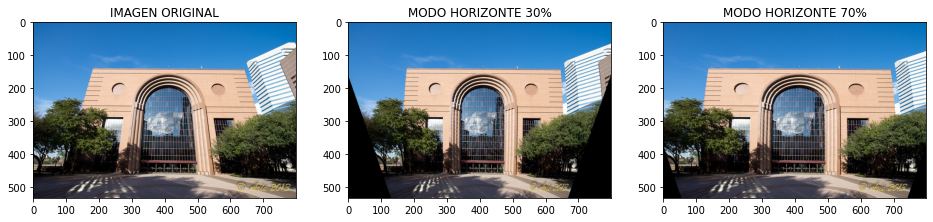

In [ ]:
fig5, (ax0,ax1,ax2) = plt.subplots(ncols=3, figsize=(16, 6))
ax0.imshow(img_1)
ax0.set_title("IMAGEN ORIGINAL")
ax1.imshow(corrige_keystone_exp(img_1,0.35,30))
ax1.set_title("MODO HORIZONTE 30%")
ax2.imshow(corrige_keystone_exp(img_1,0.35,70))
ax2.set_title("MODO HORIZONTE 70%")

#### 5.- DETERMINACIÓN AUTOMÁTICA DE ALPHA
La determinación de la pendiente alpha es el factor que indica la intensidad de la corrección a aplicar. Nos planteamos dos formas de determinarlo, una automática y otra manual. La determinación de alpha de forma automática se ha explorado buscando parametrizar la verticalidad de una imagen. De esta forma para varias alphas sería posible determinar que imagen corregida presenta una mayor cantidad de líneas verticales. También se ha buscado determinar la pendiente dominante en las rectas de la imagen buscando así una determinación directa de alpha (***Anexo A2***). Sin entrar en filtros espaciales no hemos llegado a una solución que converja en un alpha adecuado para diferentes imágenes. En todo caso se incluyen las líneas de trabajo realizadas como anexo a este laboratorio para líneas de trabajo futuras. A partir de aquí se ha determinado que puede ser útil una herramienta para determinar el alpha de forma visual, permitiendo así ajustar además el efecto deseado.

In [ ]:
#La función utiliza como argumento la imagen orifinal, un alpha inicial, un alpha final, un número de intervalos y el modo.
def compara_alphas2(img,alpha_i,alpha_f,n,modo):
    fig6, imagenes = plt.subplots(ncols=n, figsize=(16, 6))
    imagenes[0].imshow(img)
    imagenes[0].set_title("ORIGINAL")
    i=0
    for ax in imagenes[1:]:
        i=i+1
        alpha=((alpha_f-alpha_i)/n)*i
        ax.imshow(corrige_keystone(img,alpha,modo))
        ax.set_title("alpha" + str(round(alpha,2)))

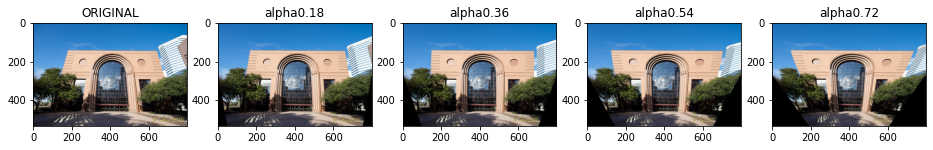

In [ ]:
compara_alphas2(img_1,0.1,1,5,"hz_sr")

#### 6.- EJEMPLOS DE USO

Text(0.5, 1.0, 'CORREGIDA')

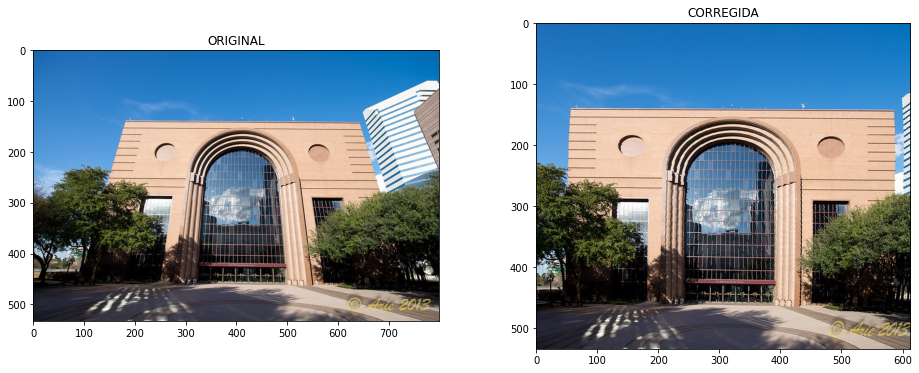

In [ ]:
fig7, (ax0,ax1) = plt.subplots(ncols=2, figsize=(16, 6))
ax0.imshow(img_1)
ax0.set_title("ORIGINAL")
ax1.imshow(corrige_keystone(img_1,0.35,"hz"))
ax1.set_title("CORREGIDA")

Text(0.5, 1.0, 'CORREGIDA')

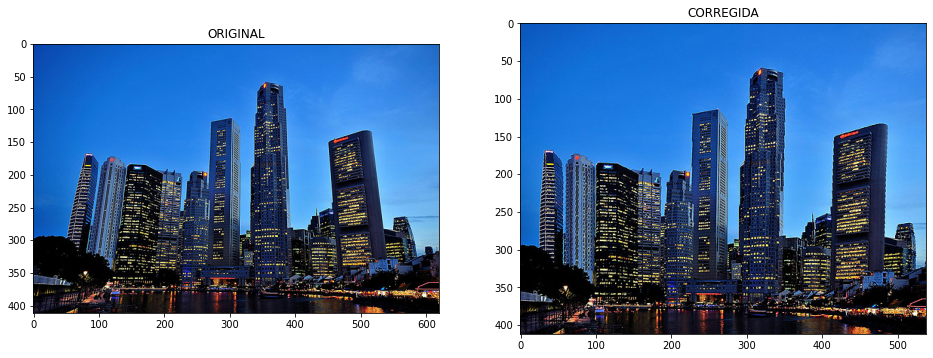

In [ ]:
fig8, (ax0,ax1) = plt.subplots(ncols=2, figsize=(16, 6))
ax0.imshow(img_2)
ax0.set_title("ORIGINAL")
ax1.imshow(corrige_keystone(img_2,0.20,"hz"))
ax1.set_title("CORREGIDA")

Text(0.5, 1.0, 'CORREGIDA')

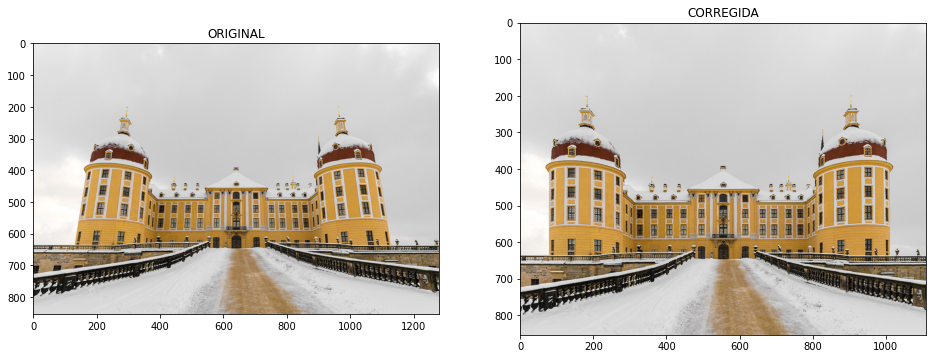

In [ ]:
fig9, (ax0,ax1) = plt.subplots(ncols=2, figsize=(16, 6))
ax0.imshow(img_3)
ax0.set_title("ORIGINAL")
ax1.imshow(corrige_keystone(img_3,0.20,"hz"))
ax1.set_title("CORREGIDA")

#### 7.- CONCLUSIONES

Consideramos que la solución propuesta corrige el efecto keystone mediante post procesado con determinación de alpha de forma manual por parte del usuario. Como líneas de mejora proponemos la detección automática del parámetro alpha, así como la eficiencia en tiempo y memoria del propio algoritmo.


#### ANEXO.- LÍNEAS DE TRABAJO PARA LA DETERMINACIÓN AUTOMÁTICA DE ALPHA

##### Búsqueda de pendientes dominantes
Este método pretende obtener alpha a través de la detección de las pendientes presentes en la imagen. A continuación de muestra el pseudocódigo que representa el funcionamiento del algoritmo

1- Carga imagen.<br>
2- Binariza imagen y detecta bordes.<br>
3- Genera rectas con pendiente 'b' y origen 0 en el intervalo deseado.<br>
4- Por cada recta: desplazar de izquierda a derecha de la imagen registrando el número de pixels atrapados por esta.<br>
5- Análisis de incrementos: para cada pendiente, el punto que registra un incremento máximo y mínimo, son los mejores candidatos de recta.<br>
6- Evaluación de candidatas: la relación entre el incremento y el número total de pixels atrapados por la recta determina la calidad de las candidatas.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import data, io, exposure, img_as_float, color
from skimage.color import rgb2hsv,rgb2gray
import matplotlib.pyplot as plt
import math
import time

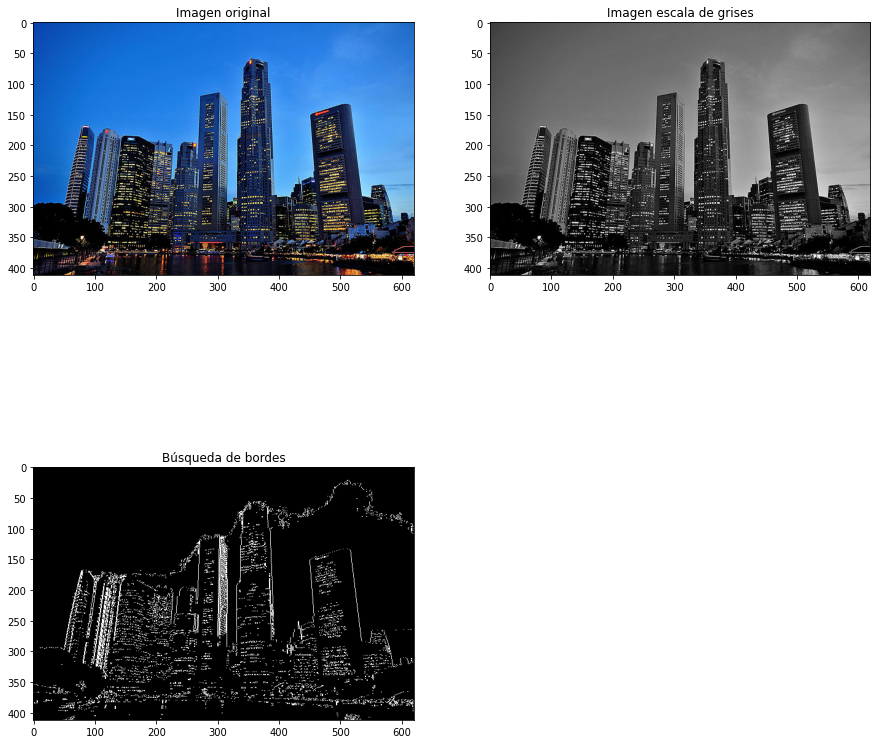

In [ ]:
# Carga imagen
img = img_2
img = img_as_float(img)
shape = np.shape(img)

#Convierto imagem a escala de grises
img_gray = rgb2gray(img)

#Aplica autocontraste 1% para (facilitará la segmentación a la hora de binarizar)
p1, p99 = np.percentile(img, (1, 99))
img_gray = exposure.rescale_intensity(img_gray, in_range=(p1, p99))

#Creo imagen binarizada con criterio -> media + complementario*f
threshold = img_gray.mean()+(1.0-img_gray.mean())*0.25
binary_img = img_gray > threshold

#Busco cambios blanco-negro y negro-blanco para detectar bordes
borders = np.zeros(shape=np.shape(img_gray),dtype=bool)

shape = np.shape(img)
for i in range(0,shape[0]):
    for j in range(0,shape[1]-1):
            if(binary_img[i][j] != binary_img[i][j+1]):
                borders[i][j]=True
                
fig1, axs = plt.subplots(ncols=2,nrows=2,figsize=(15,15))
axs[0][0].imshow(img)
axs[0][0].set_title("Imagen original")
axs[0][1].imshow(img_gray,cmap='gray')
axs[0][1].set_title("Imagen escala de grises")
axs[1][0].imshow(borders,cmap='gray')
axs[1][0].set_title("Búsqueda de bordes")
fig1.delaxes(axs[1][1])


In [ ]:
#Se realiza un barrido desde la izquierda hacia la mitad de la imagen
#el signo de  la pendiente cambia idealmente a partir de la mitad, suponiendo que la imagen está centrada
img_w = int(np.shape(img)[1]/2)
img_h = np.shape(img)[0]
slope_i = 4.0 #Pendiente mínima
slope_f = 30.0 #Pendiente máxima
slope_step=0.5 #Resolución de pendiente en el intervalo
arr_size = int(((slope_f-slope_i)/slope_step)+1)
dotcount_arr = np.zeros((arr_size,img_w)) #Número de pixels coincidentes con recta
dotcount_inc = np.zeros((arr_size,img_w)) #Incrementos de pixels capturados con respecto a la anterior recta

print("Pendientes calculadas: ",end = '')
for ii in range(0,arr_size):
    slope = float(slope_i + (ii*slope_step))
    t_init= time.perf_counter()

    x=0.0
    y=0.0
    step = float(1.0/slope)

    rect_index_j = []
    rect_index_i = []

    while int(y)<img_h and int(x)<img_w:
        y = int(slope*x)
        if(((img_h-int(y)) < img_h) and (int(x) < img_w) ):
            rect_index_j.append(int(x))
            rect_index_i.append(img_h-int(y))
        x=x+step

    np_rect_index_j = np.array(rect_index_j)
    np_rect_index_i = np.array(rect_index_i)


    for j in range(0,img_w-1,1):
        j_indexes = np_rect_index_j + j
        i_indexes = np_rect_index_i
        dots=0
        continuity_list = []
        continuity = 0
        for n in range(0,np_rect_index_j.shape[0]):
            if(i_indexes[n]>=0 and i_indexes[n]< img_h and j_indexes[n] >= 0 and j_indexes[n]< img_w):
                if(borders[i_indexes[n]][j_indexes[n]] == True):
                    dots = dots+1
                    
        #Registra número de pixels coincidentes con la recta
        dotcount_arr[ii][j] = dots 
        if(j>0):
            #Registra incremento de puntos detectados con respecto a la posición anterior
            dotcount_inc[ii][j] = dots-dotcount_arr[ii][j-1] 

        dots=0

    print(slope," ",end = '')

Pendientes calculadas: 4.0  4.5  5.0  5.5  6.0  6.5  7.0  7.5  8.0  8.5  9.0  9.5  10.0  10.5  11.0  11.5  12.0  12.5  13.0  13.5  14.0  14.5  15.0  15.5  16.0  16.5  17.0  17.5  18.0  18.5  19.0  19.5  20.0  20.5  21.0  21.5  22.0  22.5  23.0  23.5  24.0  24.5  25.0  25.5  26.0  26.5  27.0  27.5  28.0  28.5  29.0  29.5  30.0  

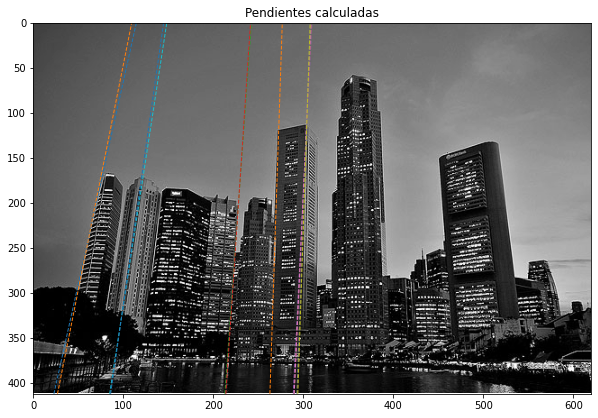

In [ ]:
#Evaluación de rectas candidatas en función de un intervalo de confianza

#Para cada pendiente calculada, la mejor candidata será la que mayor incremento de puntos detectados produzca ya que una recta
#paralela pasaría idealmente de tener cero o pocas coincidencias a un número relativamente alto.

#Cuanto más cercano sea el valor del incremento al número total de puntos, más probabilidad hay de que sea una recta válida

line_threshold = 0.75

evaluated = np.zeros((np.shape(dotcount_arr)[0],3),dtype=float)
evaluated_min = np.zeros((np.shape(dotcount_arr)[0],3),dtype=float)

for i in range(np.shape(dotcount_inc)[0]):
    indexes = np.where(dotcount_inc[i,:] == np.amax(dotcount_inc[i,:]))
    index = indexes[0][0]
    count = dotcount_arr[i,index]
    increment = dotcount_inc[i,index]
    value = increment/count    
    evaluated[i][0] = float(i*slope_step)+slope_i
    evaluated[i][1] = float(index)
    evaluated[i][2] = value
    
    indexes_min = np.where(dotcount_inc[i,:] == np.amin(dotcount_inc[i,:]))    
    index_min = indexes_min[0][0]
    increment_min = dotcount_inc[i,index_min]
    count_min = dotcount_arr[i,index_min]
    value_min = float(1.0 - np.abs(count_min/increment_min))
    evaluated_min[i][0] = float(i*slope_step)+slope_i
    evaluated_min[i][1] = float(index_min)
    evaluated_min[i][2] = value_min
    
#Comprobación visual de pendientes
#cambiar 'line_threshold' (0.1-1.0) para ajustar el criterio mínimo de selección de pendientes

lines = evaluated[evaluated[:,2] >= line_threshold]
lines_min = evaluated_min[evaluated_min[:,2] >= line_threshold]
x = np.array(range(np.shape(borders)[1]))

fig2, axs= plt.subplots(ncols=1,nrows=1,figsize=(10, 15))
#axs.imshow(borders2,cmap='gray')
axs.imshow(img_gray,cmap='gray')
axs.set_title("Pendientes calculadas")
axs.axis(xmin=0,xmax=np.shape(borders)[1],ymin=np.shape(borders)[0],ymax=0)

for i in range(np.shape(lines)[0]):
    b = lines[i,0]
    xv = lines[i,1]
    y2 = b*x
    axs.plot(x+xv,np.shape(borders)[0]-y2,linewidth=1,linestyle='dashed')
    
for i in range(np.shape(lines_min)[0]):
    b = lines_min[i,0]
    xv = lines_min[i,1]
    y2 = b*x
    axs.plot(x+xv,np.shape(borders)[0]-y2,linewidth=1,linestyle='dashed')


**Conclusiones:** parece funcionar relativamente bien pero se observan las siguientes desventajas.<br>
- Depende fuertemente de la calidad de la detección automática de bordes<br>
- No funciona bien con rectas verticales o de pendiente muy alta, solo se puede aproximar, puesto que la pendiente vertical es infinita, por lo que lo ideal sería utilizar coordenadas polares, como se propone en la <a href="https://es.wikipedia.org/wiki/Transformada_de_Hough">transformada de Hough</a>, para detección de figuras.